# C04. Players

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

### Dates

In [2]:
start_date = "20220407"
end_date = yesterdaysdate

### Games

In [3]:
game_df = read_and_save_games(team_map, generate=True)
game_df = game_df[(game_df['date'] >= start_date) & (game_df['date'] <= end_date)].reset_index(drop=True)

In [4]:
date_list = list(game_df['date'].unique())
date_folders = [f"Matchups {date}" for date in date_list]

game_list = list(game_df['game_id'].unique())
player_folders = [f"Players {game}" for game in game_list]

In [5]:
# %run "C:\Users\james\Documents\MLB\Code\C02. Projections.ipynb"

### Create Player Stat Dataframe

Extract date, teams, and gamePk from folder names

In [6]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [7]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates().set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Average Projections

##### Batters

Calculate averages

In [8]:
%%time
position = 'batters'

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 33.1 s
Wall time: 1h 17min 39s


Write to csv

In [9]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages.

In [10]:
%%time
position = 'pitchers'

# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 32.9 s
Wall time: 1h 18min 16s


Write to csv

In [11]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Evaluate Projections

In [12]:
# Define a function to process each folder
def process_batters(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]

    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append them together
    batters_merged = pd.concat([away_batters_merged, home_batters_merged], axis=0)

    
    return batters_merged

In [21]:
def process_batters2(folder):
    try:
        batters_merged = process_batters(folder)    
        return batters_merged   
    except:
        pass 

In [22]:
%%time
# Run the loop in parallel
batters_merged_list = Parallel(n_jobs=-1)(delayed(process_batters2)(folder) for folder in player_folders)
batters_merged_df = pd.concat(batters_merged_list, axis=0)

CPU times: total: 5.77 s
Wall time: 11.1 s


In [14]:
def process_pitchers(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]
    
    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append them together
    pitchers_merged = pd.concat([away_pitchers_merged, home_pitchers_merged], axis=0)

    
    return pitchers_merged

In [24]:
def process_pitchers2(folder):
    try:
        pitchers_merged = process_pitchers(folder)    
        return pitchers_merged   
    except:
        pass 

In [25]:
%%time
# Run the loop in parallel
pitchers_merged_list = Parallel(n_jobs=-1)(delayed(process_pitchers2)(folder) for folder in player_folders)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

CPU times: total: 4.84 s
Wall time: 9.51 s


### Batters

##### Create New Variables

In [26]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [27]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
batters_merged_df['battersSpot'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Starters - Never Subbed

In [28]:
batters_merged_df.query('substitution == False').query('battersSpot == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

,PA,pa,ON,on,H,h,B1,singles,B2,doubles,B3,triples,HR,hr,BB,bb,SB,sb,FP,fp
mean,4.197160,4.13424,1.311509,1.310424,0.915095,0.920741,0.581271,0.593245,0.183935,0.183688,0.017402,0.015826,0.133281,0.127983,0.350457,0.346741,0.086442,0.070569,7.287873,7.158886
sum,353220.396329,348227.00000,110468.374504,110377.000000,77078.448909,77554.000000,48917.996528,49969.000000,15479.386409,15472.000000,1464.522321,1333.000000,11216.543651,10780.000000,29493.417659,29206.000000,7274.734623,5944.000000,613325.557044,602993.000000


##### Teams

In [29]:
batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

,PA,pa,ON,on,H,h,B1,singles,B2,doubles,B3,triples,HR,hr,BB,bb,HBP,hbp,R,r,RBI,rbi,SB,sb,FP,fp
mean,37.645980,37.287915,11.752871,11.823432,8.194918,8.248893,5.203021,5.331734,1.646383,1.648801,0.156128,0.137823,1.189385,1.130535,3.141831,3.165959,0.416123,0.408579,4.393622,4.429428,4.224688,4.235978,0.763632,0.626845,65.154543,64.261255
sum,408082.420635,404201.000000,127401.125992,128166.000000,88832.908234,89418.000000,56400.748016,57796.000000,17846.797123,17873.000000,1692.426587,1494.000000,12892.936508,12255.000000,34057.444444,34319.000000,4510.773313,4429.000000,47626.859127,48015.000000,45795.623016,45918.000000,8277.768353,6795.000000,706275.249008,696592.000000


##### Scaled

In [58]:
actual_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['pa'].mean()
projected_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['PA'].mean()

In [31]:
# Define the fraction
fraction = actual_pa_mean/projected_pa_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['PA', 'H', 'B1', 'B2', 'B3', 'HR', 'BB', 'HBP', 'R', 'RBI', 'SB', 'FP']
batters_merged_df_scaled = batters_merged_df.copy()
batters_merged_df_scaled[columns_to_multiply] = batters_merged_df[columns_to_multiply] * fraction

# Describe the DataFrame
description = batters_merged_df_scaled.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']]


# Print the description
description.describe()

,PA,pa,ON,on,H,h,B1,singles,B2,doubles,B3,triples,HR,hr,BB,bb,HBP,hbp,R,r,RBI,rbi,SB,sb,FP,fp
count,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000
mean,37.066238,37.287915,11.752871,11.823432,8.068717,8.248893,5.122895,5.331734,1.621029,1.648801,0.153724,0.137823,1.171069,1.130535,3.093447,3.165959,0.409715,0.408579,4.325961,4.429428,4.159629,4.235978,0.751872,0.626845,64.151174,64.261255
std,1.241526,4.500560,0.850241,4.287483,0.672474,3.378081,0.498675,2.582723,0.192810,1.343283,0.043030,0.381084,0.212387,1.137323,0.459752,2.015084,0.095968,0.648147,0.530222,3.160177,0.516734,3.084180,0.672792,0.946175,6.269753,30.545990
min,12.338271,18.000000,3.812500,0.000000,2.584575,0.000000,1.630744,0.000000,0.369225,0.000000,0.000000,0.000000,0.246150,0.000000,0.799988,0.000000,0.092306,0.000000,0.923063,0.000000,0.830756,0.000000,0.092306,0.000000,16.830509,0.000000
25%,36.285397,34.000000,11.216270,9.000000,7.638221,6.000000,4.797728,3.000000,1.499366,1.000000,0.126982,0.000000,1.023672,0.000000,2.769188,2.000000,0.342852,0.000000,3.981379,2.000000,3.821186,2.000000,0.434670,0.000000,60.099681,42.000000
50%,36.953275,37.000000,11.753968,11.000000,8.070205,8.000000,5.123242,5.000000,1.615604,1.000000,0.149448,0.000000,1.163352,1.000000,3.076875,3.000000,0.396575,0.000000,4.309579,4.000000,4.144502,4.000000,0.560675,0.000000,63.746999,60.000000
75%,37.882931,40.000000,12.294891,15.000000,8.495107,10.000000,5.444604,7.000000,1.735748,2.000000,0.173868,0.000000,1.307916,2.000000,3.389447,4.000000,0.461531,1.000000,4.664153,6.000000,4.489308,6.000000,0.719891,1.000000,67.673923,82.000000
max,41.691663,68.000000,16.031250,35.000000,11.169058,29.000000,7.359105,19.000000,2.738419,9.000000,0.492300,3.000000,2.102043,7.000000,5.199920,17.000000,1.011950,5.000000,7.353732,28.000000,7.015276,28.000000,4.799926,9.000000,100.983054,256.000000


In [32]:
# This is scaled?
description['SAFE'] = description[['H', 'BB', 'HBP']].sum(axis=1)
description['safe'] = description[['h', 'bb', 'hbp']].sum(axis=1)

description['SAFE'].mean()/description['PA'].mean(), description['safe'].mean()/description['pa'].mean()

(0.312194594890524, 0.3170848167124772)

In [33]:
# Consider tracking if players were never removed from game
# Consider merging on innings and only looking at full games

### Pitchers

##### Create New Variables

In [34]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [35]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Starters

In [36]:
pitchers_merged_df.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].describe()

,OUT,outs,PA,pa,ER,er,R,r,H,h,SO,k,W,w,FP,fp
count,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000
mean,15.844492,15.490200,22.341365,21.856791,2.429937,2.426278,2.639762,2.595489,4.998825,4.936472,4.968840,4.778292,0.307173,0.291244,14.038008,13.414528
std,1.318390,4.414556,1.636246,4.854033,0.355239,1.987576,0.377242,2.049036,0.559855,2.276192,0.967463,2.517862,0.074326,0.454358,3.186856,10.990660
min,0.375000,0.000000,0.562500,0.000000,0.062500,0.000000,0.062500,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.150000,-26.050000
25%,15.156746,13.000000,21.625992,20.000000,2.214286,1.000000,2.410714,1.000000,4.687500,3.000000,4.312500,3.000000,0.255952,0.000000,11.839137,5.800000
50%,15.842262,16.000000,22.412698,23.000000,2.429563,2.000000,2.642857,2.000000,5.015873,5.000000,4.892857,5.000000,0.304563,0.000000,13.802778,13.150000
75%,16.562500,18.000000,23.164683,25.000000,2.651786,4.000000,2.875000,4.000000,5.339286,6.000000,5.559524,6.000000,0.354167,1.000000,16.039137,21.100000
max,25.910714,27.000000,36.429563,35.000000,4.218750,13.000000,4.392857,13.000000,8.266865,14.000000,10.260913,16.000000,0.718750,1.000000,32.140526,52.800000


##### Scaled

This calculates how starting pitchers would do if they went as long as they were supposed to. <br>
Note: outs should have a nonlinear relationship with wins, so this won't be exactly right, but close enough. 

In [37]:
actual_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['outs'].mean()
projected_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['OUT'].mean()

In [38]:
# Define the fraction
fraction = actual_outs_mean/projected_outs_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['OUT', 'ER', 'R', 'SO', 'FP']
pitchers_merged_df_scaled = pitchers_merged_df.copy()
pitchers_merged_df_scaled[columns_to_multiply] = pitchers_merged_df_scaled[columns_to_multiply] * fraction

# Describe the DataFrame
description = pitchers_merged_df_scaled.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'W', 'w', 'FP', 'fp']].describe()

# Print the description
description

,OUT,outs,PA,pa,ER,er,R,r,SO,k,W,w,FP,fp
count,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000,10153.000000
mean,15.490200,15.490200,22.341365,21.856791,2.375602,2.426278,2.580735,2.595489,4.857733,4.778292,0.307173,0.291244,13.724109,13.414528
std,1.288910,4.414556,1.636246,4.854033,0.347296,1.987576,0.368807,2.049036,0.945830,2.517862,0.074326,0.454358,3.115596,10.990660
min,0.366615,0.000000,0.562500,0.000000,0.061102,0.000000,0.061102,0.000000,0.122205,0.000000,0.000000,0.000000,0.146646,-26.050000
25%,14.817832,13.000000,21.625992,20.000000,2.164773,1.000000,2.356809,1.000000,4.216070,3.000000,0.255952,0.000000,11.574407,5.800000
50%,15.488020,16.000000,22.412698,23.000000,2.375237,2.000000,2.583761,2.000000,4.783450,5.000000,0.304563,0.000000,13.494140,13.150000
75%,16.192153,18.000000,23.164683,25.000000,2.592490,4.000000,2.810713,4.000000,5.435210,6.000000,0.354167,1.000000,15.680492,21.100000
max,25.331335,27.000000,36.429563,35.000000,4.124416,13.000000,4.294630,13.000000,10.031473,16.000000,0.718750,1.000000,31.421845,52.800000


### Teams

In [39]:
pitchers_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].describe()

,OUT,outs,PA,pa,ER,er,R,r,SO,k,H,h,BB,bb,HR,hr,FP,fp
count,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000,10817.000000
mean,26.670131,26.628640,37.675132,37.653046,3.975746,4.067024,4.397024,4.432652,8.765241,8.524082,8.201110,8.255339,3.144423,3.168161,1.190321,1.131737,24.531535,23.812351
std,0.765240,1.949369,1.092186,4.607655,0.505195,3.032406,0.534421,3.160657,1.149309,2.946515,0.669472,3.375681,0.464300,2.015636,0.214982,1.137678,3.640356,12.523981
min,24.437500,24.000000,33.875000,12.000000,1.960317,0.000000,2.207341,0.000000,5.211310,0.000000,5.078373,0.000000,1.812500,0.000000,0.437500,0.000000,11.617708,-44.750000
25%,25.936508,27.000000,36.859127,34.000000,3.639881,2.000000,4.046627,2.000000,7.970238,6.000000,7.760913,6.000000,2.814484,2.000000,1.040675,0.000000,22.021875,15.650000
50%,27.000000,27.000000,37.534722,37.000000,3.959325,4.000000,4.377976,4.000000,8.719246,8.000000,8.199405,8.000000,3.125000,3.000000,1.181548,1.000000,24.390774,24.800000
75%,27.404762,27.000000,38.477183,40.000000,4.297619,6.000000,4.740079,6.000000,9.529762,10.000000,8.628968,10.000000,3.444444,4.000000,1.328373,2.000000,26.903323,32.850000
max,28.473214,54.000000,42.343750,69.000000,6.875000,27.000000,7.468750,28.000000,14.183532,22.000000,11.343750,29.000000,5.281250,17.000000,2.134921,7.000000,43.617262,81.900000


### Read in projections

##### DFF - Date-Based

In [40]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


##### DFF - Slate-Based

In [41]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(29338, 22)


In [42]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

In [43]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

In [44]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

In [45]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

In [46]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

In [47]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### All

In [48]:
batters_with_dff.query('FP > 5 and FP_DFF > 5')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,47852.000000,47852.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47852.000000
mean,7.487763,7.600657,7.115092,-0.372770,-0.485603,51.331090,51.040672,0.512685
std,1.320905,1.445152,7.232681,7.154943,7.127827,103.374803,102.091263,0.499844
min,5.001984,5.002000,0.000000,-15.500000,-29.980000,0.000000,0.000000,0.000000
25%,6.539683,6.600000,2.000000,-5.746032,-5.800000,6.455027,6.350400,0.000000
50%,7.327381,7.480000,5.000000,-2.312500,-2.400000,25.724419,26.010000,1.000000
75%,8.232143,8.400000,10.000000,3.002480,2.886500,53.472656,54.619491,1.000000
max,17.093750,31.980000,68.000000,59.807540,58.600000,3576.941803,3433.960000,1.000000


##### Winsorized

In [49]:
# Winsorize the DataFrame
batters_winsorized = batters_with_dff.query('FP > 5 and FP_DFF > 5')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Describe the winsorized DataFrame
batters_winsorized.describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,47852.000000,47852.000000,47852.000000,47852.000000,47852.000000,47852.000000,47852.000000,47852.000000
mean,7.447016,7.553391,6.817646,-0.592788,-0.704312,41.044258,40.883045,0.512685
std,1.152857,1.209988,6.374859,6.307998,6.275285,48.462467,47.686836,0.499844
min,5.665675,5.610000,0.000000,-8.134921,-8.215000,0.279598,0.250000,0.000000
25%,6.539683,6.600000,2.000000,-5.745040,-5.800000,6.460069,6.378151,0.000000
50%,7.327381,7.480000,5.000000,-2.312500,-2.400000,25.749584,26.010000,1.000000
75%,8.232143,8.400000,10.000000,3.008185,2.894000,53.472656,54.641664,1.000000
max,9.816468,9.984000,21.000000,13.767857,13.600000,189.922852,187.690000,1.000000


##### Pitchers

In [50]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

In [51]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### All

In [52]:
pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,5435.000000,5435.000000,5435.000000,5435.000000,5435.000000,5.435000e+03,5435.000000,5435.000000
mean,14.103286,13.712371,13.645547,-0.457739,-0.066824,1.076790e+02,104.774723,0.483717
std,3.163970,3.947701,10.981874,10.367704,10.236676,1.505113e+02,149.842035,0.499781
min,0.514335,0.636000,-26.050000,-37.403522,-37.875000,3.543084e-07,0.000000,0.000000
25%,11.930233,11.313500,6.050000,-7.416295,-6.800000,1.108368e+01,9.878498,0.000000
50%,13.950744,13.700000,13.450000,-0.369395,0.050000,5.000300e+01,46.922500,0.000000
75%,16.119370,16.300000,21.300000,6.618118,6.950000,1.428147e+02,135.722500,1.000000
max,32.140526,29.267000,47.650000,36.939063,37.040000,1.399023e+03,1434.515625,1.000000


In [53]:
pitchers_with_dff.query('FP > 10').dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4.992000e+03,4992.000000,4992.000000
mean,14.588110,14.114336,14.140294,-0.447816,0.025958,1.096427e+02,106.627797,0.484776
std,2.791767,3.797897,10.985842,10.462509,10.327075,1.511848e+02,151.042517,0.499818
min,10.001339,0.636000,-26.050000,-37.403522,-37.875000,3.543084e-07,0.000000,0.000000
25%,12.488554,11.880000,6.500000,-7.557812,-6.800000,1.192347e+01,9.965086,0.000000
50%,14.252951,14.100000,14.100000,-0.351649,0.150000,5.180144e+01,48.874130,0.000000
75%,16.338579,16.500000,21.850000,6.764621,7.135000,1.472629e+02,138.109516,1.000000
max,32.140526,29.267000,47.650000,31.695312,37.040000,1.399023e+03,1434.515625,1.000000


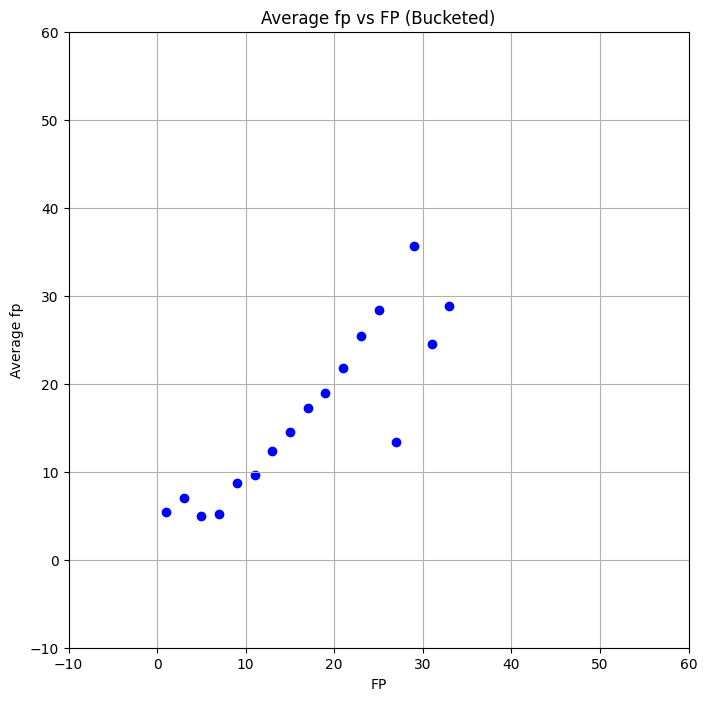

In [57]:
import numpy as np

df = pitchers_with_dff.query('starter == 1').dropna()

# Bucketing the data based on intervals of 0.5 for FP
bucket_size = 2
FP_bucketed = np.floor(df['FP'] / bucket_size) * bucket_size

# Calculating the average fp for each bucket
grouped_data = df.groupby(FP_bucketed)['fp'].mean()

# Getting the center of each bucket
bucket_centers = (grouped_data.index + bucket_size / 2)

# Creating scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(bucket_centers, grouped_data, color='blue')
plt.title('Average fp vs FP (Bucketed)')
plt.xlabel('FP')
plt.ylabel('Average fp')
plt.grid(True)

# Set the same intervals on each side from -10 to 60
plt.xlim(-10, 60)
plt.ylim(-10, 60)

plt.show()


##### Winsorized

In [56]:
# Winsorize the DataFrame
pitchers_winsorized = pitchers_with_dff.query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Describe the winsorized DataFrame
pitchers_winsorized.describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000
mean,14.082952,13.734657,13.652004,-0.436771,-0.042282,98.453336,95.755893,0.483824
std,2.803653,3.441983,10.076913,9.443986,9.311817,116.843183,116.320564,0.499784
min,9.326042,7.100000,-4.050000,-17.609127,-17.400000,0.391866,0.354025,0.000000
25%,11.931163,11.315750,6.050000,-7.408259,-6.800000,11.068659,9.825097,0.000000
50%,13.950868,13.700000,13.450000,-0.373810,0.050000,49.971611,46.922500,0.000000
75%,16.119258,16.300000,21.300000,6.616090,6.950000,142.802056,135.722500,1.000000
max,19.475645,19.900000,31.900000,16.178869,16.380000,416.170119,414.122500,1.000000
